In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
from urllib.parse import quote
import datetime
import seaborn as sns
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt

import statsmodels.api as sm
from pylab import rcParams

import warnings; 
warnings.filterwarnings("ignore")

In [3]:
# Import libraries and set parameters 

import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
# plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['grid.linestyle'] = ':'   
plt.rcParams['axes.grid'] = True

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.color_palette("RdBu", n_colors=10)

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version', sns.__version__)

Numpy version 1.26.4
Pandas version 2.2.2
Seaborn version 0.13.2


In [4]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum()/len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100
    
    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me,rmse,mape,wape))

In [5]:
cur_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("current times:", cur_time)

current times: 2024-07-25 09:11:04


In [6]:
case = pd.read_csv("../r506_pipeline/data/df2.csv", encoding="cp874" )
temp = pd.read_csv("../temp_pipeline/data/dataset/temp.csv", encoding="cp874")

In [7]:
case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        232 non-null    object
 1   total_case  232 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


In [8]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    312 non-null    object 
 1   temp    312 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [21]:
df = case.merge(temp,on='date',how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.6+ KB


In [25]:
# Create pandas time series with date labels correctly shown. 
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
#df['rolling_weekly_avg'] = df.new_cases.rolling(window=7).mean().fillna(0)

# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':df.index,'y':df.total_case})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts.describe()

,ds,y
count,232,232.000000
mean,2021-07-10 09:43:26.896551680,22.500000
min,2019-01-07 00:00:00,1.000000
25%,2020-02-16 06:00:00,4.000000
50%,2021-06-23 00:00:00,19.000000
75%,2022-11-18 18:00:00,32.000000
max,2023-12-29 00:00:00,104.000000
std,NaN,20.103843


In [23]:
ts.tail(2)
ts.info()

,ds,y
230,230,11
231,231,22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ds      232 non-null    int64
 1   y       232 non-null    int64
dtypes: int64(2)
memory usage: 3.8 KB


<Axes: xlabel='date'>

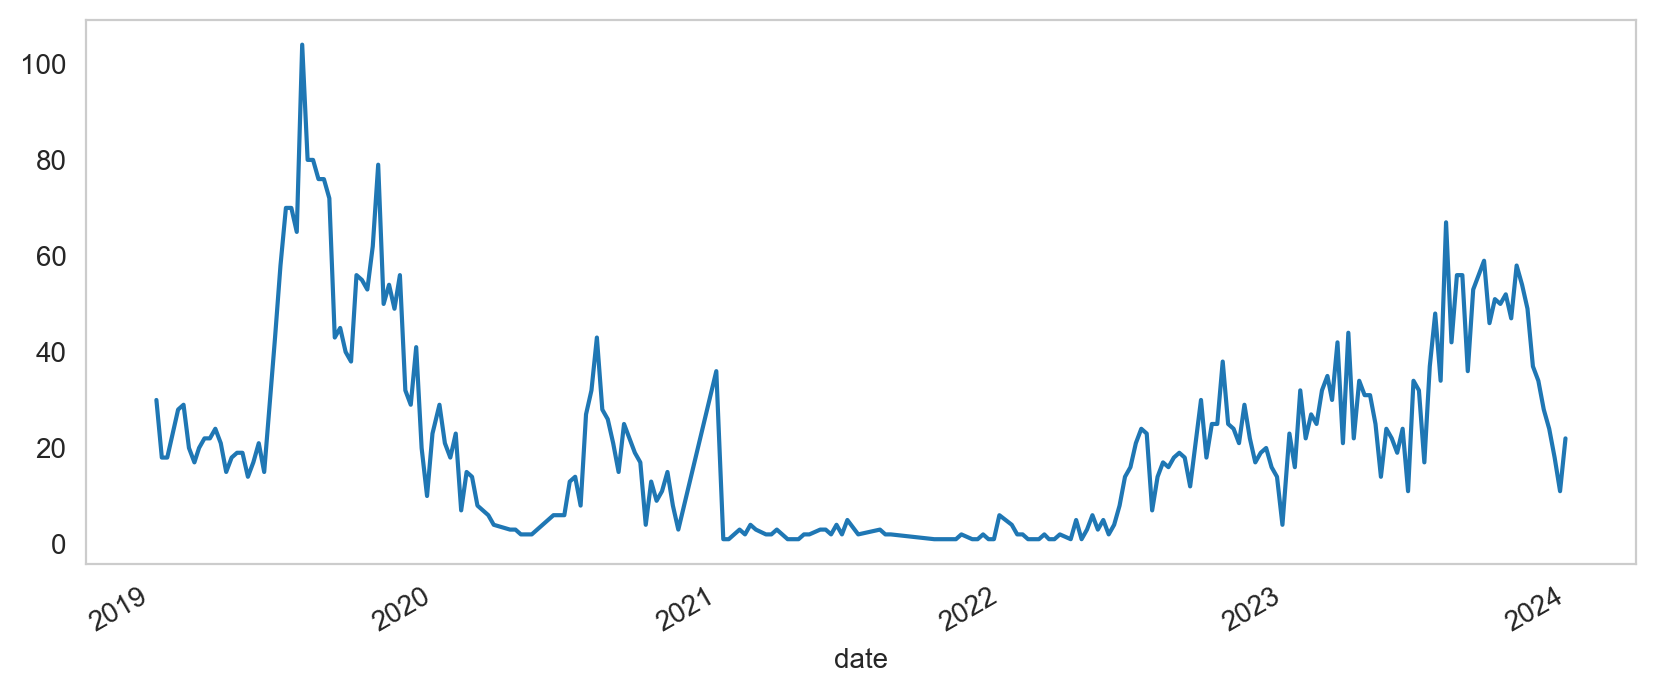

In [26]:
ts['y'].plot(figsize=(10,4))

09:14:14 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing


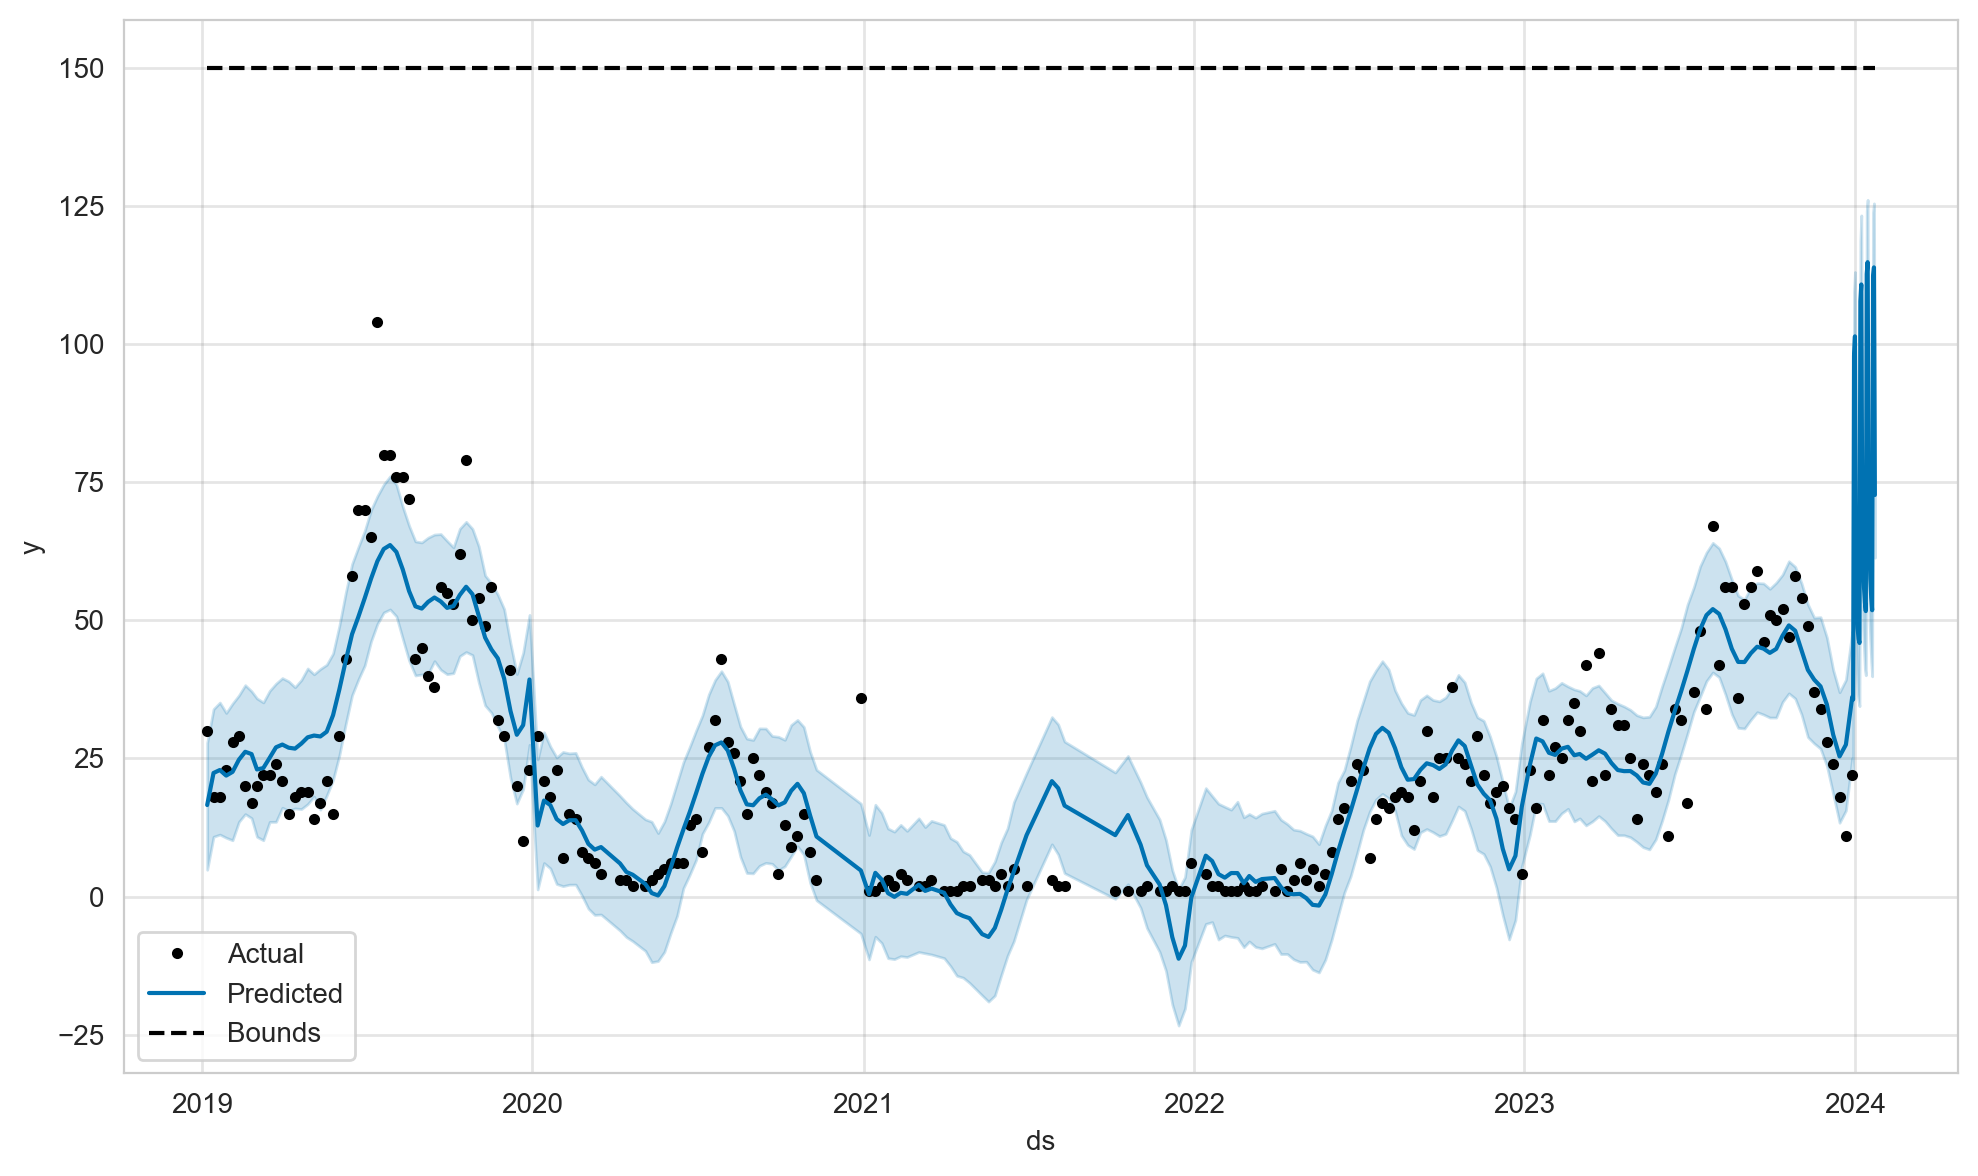

In [27]:
from prophet import Prophet

# instantiate the model and fit the timeseries
prophet = Prophet(yearly_seasonality=True, 
                  daily_seasonality=True, 
                  weekly_seasonality=True,
                  growth='linear',
                  n_changepoints= 10,
                  changepoint_range=1, # Consider the whole range for change points
                  changepoint_prior_scale=0.4) # Adjust trend flexibility if it overfits (too large) or underfits (too small).
                                               # Higher value = More flexible trend
prophet.fit(ts)

# Create additional points 25 periods into a future data frame 
future = prophet.make_future_dataframe(periods=25)
future['cap'] = 150
future['floor'] = 0 
forecast = prophet.predict(future)

# plot
fig = prophet.plot(forecast)
ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Bounds'])  
pass; 

In [28]:
# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-07,16.570216,4.847816,27.828295
1,2019-01-14,22.370763,10.826647,33.935505
2,2019-01-21,22.910670,11.222592,35.118465
3,2019-01-28,21.896900,10.645872,33.236575
4,2019-02-04,22.569028,10.189457,34.937486


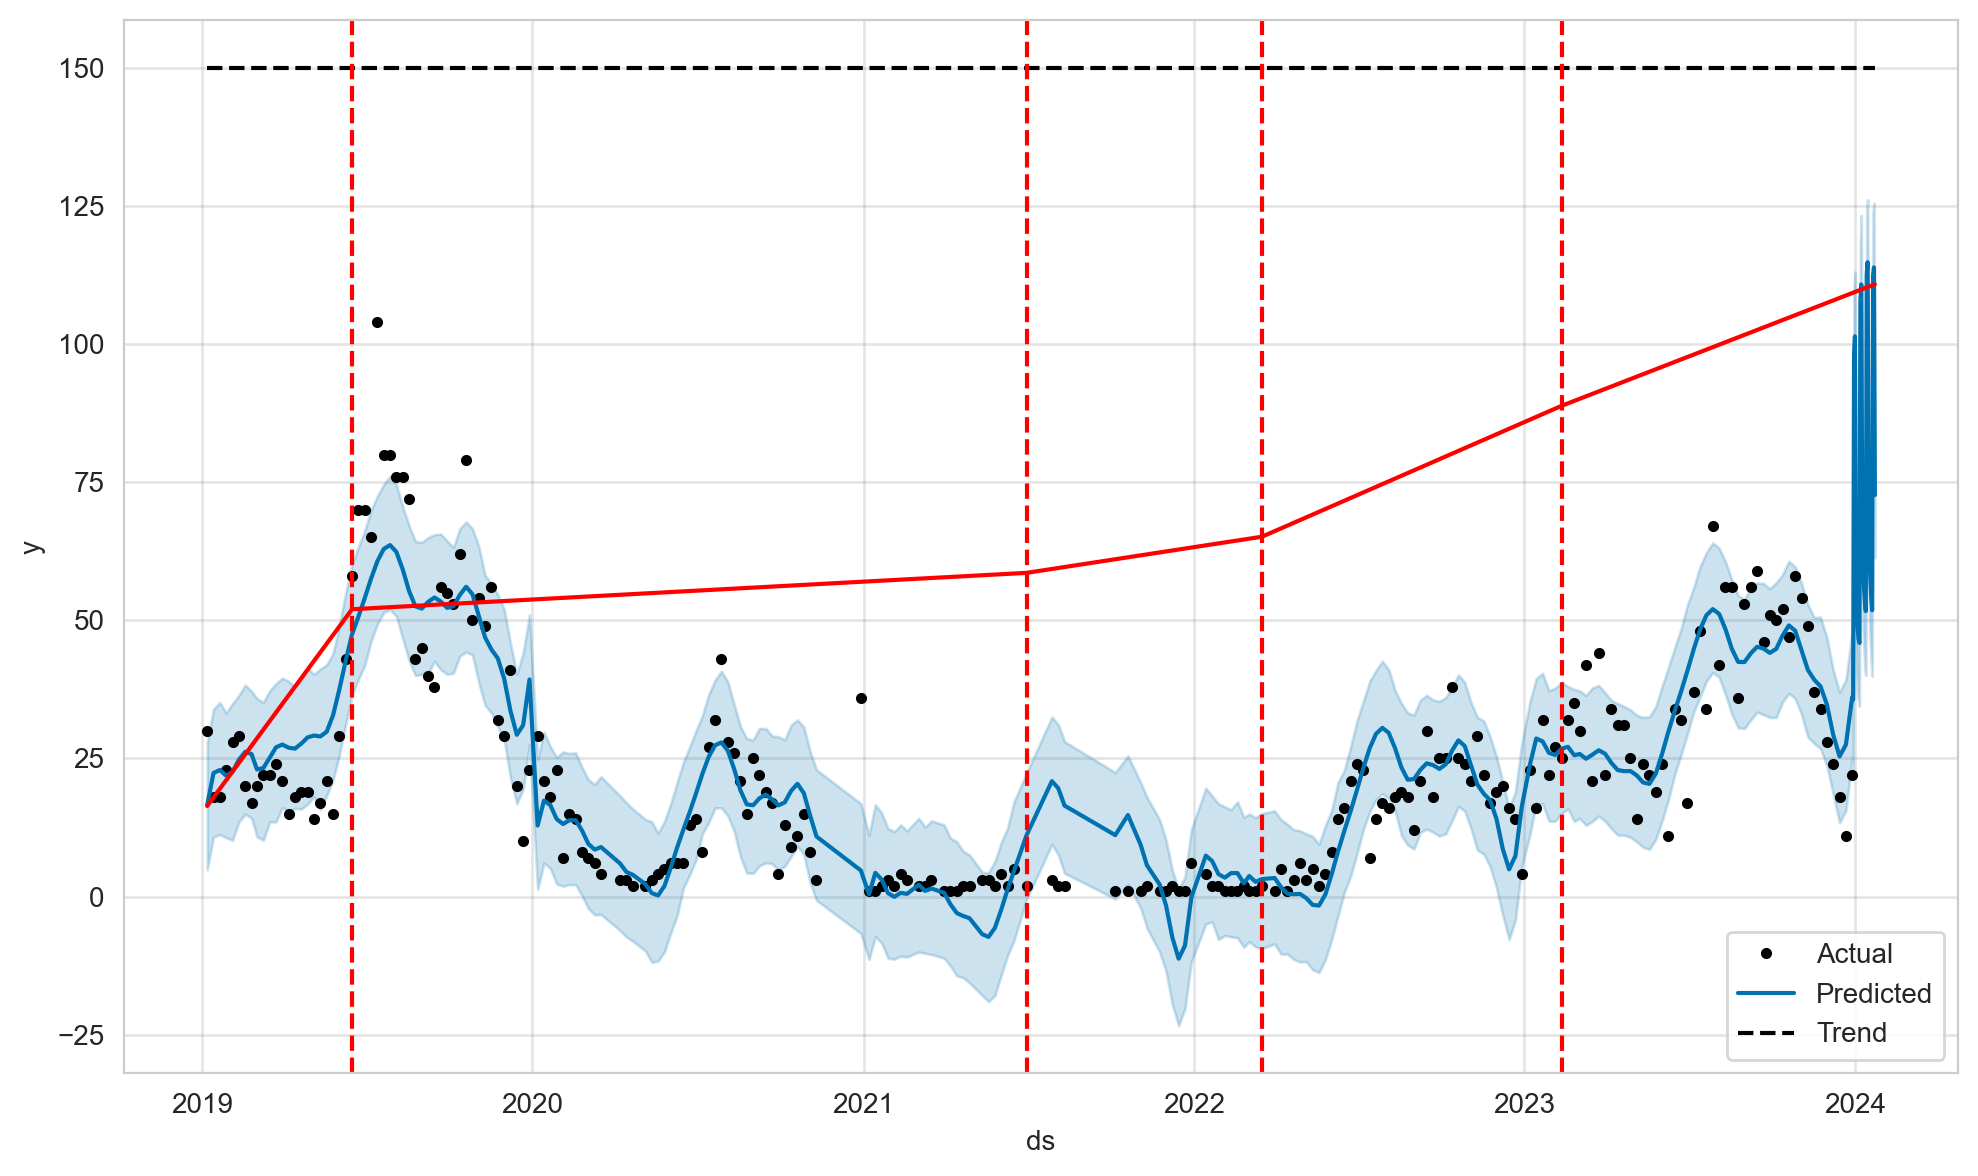

In [29]:
from prophet.plot import add_changepoints_to_plot

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Trend'])  

In [39]:
df.to_csv(r"data\case_temp.csv")

In [40]:
from statsmodels.tsa.statespace.varmax import VARMAX

VARMAR

In [41]:
uscon = pd.read_csv('data/case_temp.csv',header=0)
uscon.head()

,date,total_case,temp
0,2019-01-07,30,27.282259
1,2019-01-14,18,27.177412
2,2019-01-21,18,26.849482
3,2019-01-28,23,27.270083
4,2019-02-04,28,27.903425


In [42]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.6+ KB


In [44]:
# Create pandas time series with date labels correctly shown. 
uscon.date = pd.to_datetime(uscon.date)
uscon.set_index('date',inplace=True)

In [ ]:
# uscon = uscon.resample('W').asfreq()
# uscon.head(50)

### Find best order to fit k_AR_diff

In [47]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(uscon)
print(model.select_order())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 8, BIC -> 2, FPE -> 8, HQIC ->  2>


### ADFuller Test

In [48]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is trend stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is stostochastic trend")

In [49]:
for name, column in uscon.items():
    Augmented_Dickey_Fuller_Test_func(uscon[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: total_case
Test Statistic                  -2.956608
p-value                          0.039150
No Lags Used                     5.000000
Number of Observations Used    226.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: temp
Test Statistic                  -3.062999
p-value                          0.029415
No Lags Used                     2.000000
Number of Observations Used    229.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary




### Test for Cointegration

In [50]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,0,3)
    traces = res.lr1        # statistical test values
    cvts = res.cvt[:,1]     # critical value at 95% CI
    print('Column Name > Test Stat > C(95%) => Significant')
    print('----------------------------------------------')
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, '>', round(trace,2), ">", round(cvt,2), '=>' , trace > cvt)

In [51]:
cointegration_test(uscon)

Column Name > Test Stat > C(95%) => Significant
----------------------------------------------
total_case > 19.13 > 15.49 => True
temp > 6.59 > 3.84 => True


### Split the data set 

In [52]:
split_ratio = 0.7
train_size = int(len(uscon)*split_ratio)
Y_train, Y_test = uscon[:train_size], uscon[train_size:]

In [53]:
uscon

,total_case,temp
date,,
2019-01-07,30,27.282259
2019-01-14,18,27.177412
2019-01-21,18,26.849482
2019-01-28,23,27.270083
2019-02-04,28,27.903425
...,...,...
2023-12-01,28,26.863721
2023-12-08,24,26.813490
2023-12-15,18,27.116654


### Grid search VARMA

In [54]:
import itertools

def grid_search_VARMA(Y_train, max_p, max_q):

    results = []

    pq = np.arange(max_p+1), np.arange(max_q+1) 

    for p, q in itertools.product(*pq):
        order = (p, q)
        if order != (0, 0):
            model = VARMAX(Y_train, order=order)
            model_fit = model.fit(disp=False)
            error = model_fit.aicc
            results.append((order, error))
            print(f'VARMAX{order} - AICC:{error}')

    return results

In [55]:
results = grid_search_VARMA(Y_train,3,3)

VARMAX(0, 1) - AICC:1759.246799436312
VARMAX(0, 2) - AICC:1701.3532644210743
VARMAX(0, 3) - AICC:1689.3366089793158
VARMAX(1, 0) - AICC:1524.6403204428532
VARMAX(1, 1) - AICC:1508.303647804818
VARMAX(1, 2) - AICC:1515.42700475306


KeyboardInterrupt: 

In [103]:
# Print top 10 best models
print("\nTop 10 best VARMAX configurations:")
for i, (order, error) in enumerate(sorted(results, key=lambda x: x[1])[:10]):
    print(f'{i+1}: VARMAX{order} - AICC:{error}')


Top 10 best VARMAX configurations:
1: VARMAX(2, 0) - AICC:1502.0226780701287
2: VARMAX(3, 0) - AICC:1503.876879317861
3: VARMAX(1, 1) - AICC:1508.303647804818
4: VARMAX(2, 1) - AICC:1508.9796578756816
5: VARMAX(1, 3) - AICC:1510.4214240579108
6: VARMAX(3, 1) - AICC:1513.8731156175156
7: VARMAX(1, 2) - AICC:1515.42700475306
8: VARMAX(2, 3) - AICC:1518.652510554597
9: VARMAX(2, 2) - AICC:1519.061571519041
10: VARMAX(3, 2) - AICC:1521.440233438776


### Fit best model

best_pq = (1,3) 

In [127]:
best_pq = (2,0)

model = VARMAX(Y_train, order=best_pq, trend='c').fit(disp=False)
model.summary()

Dep. Variable:,"['total_case', 'temp']",No. Observations:,162
Model:,VAR(2),Log Likelihood,-736.782
,+ intercept,AIC,1499.563
Date:,"Thu, 25 Jul 2024",BIC,1539.702
Time:,01:32:13,HQIC,1515.860
Sample:,0,,
,- 162,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.18, 0.58",Jarque-Bera (JB):,"250.94, 2.35"
Prob(Q):,"0.67, 0.45",Prob(JB):,"0.00, 0.31"
Heteroskedasticity (H):,"0.08, 1.69",Skew:,"1.07, -0.29"


In [210]:
model.forecast(4)

,total_case,temp
162,18.727666,28.141517
163,18.918375,28.067660
164,19.205930,28.069823
165,19.418388,28.044618


### Fitted values

<Figure size 1000x400 with 0 Axes>

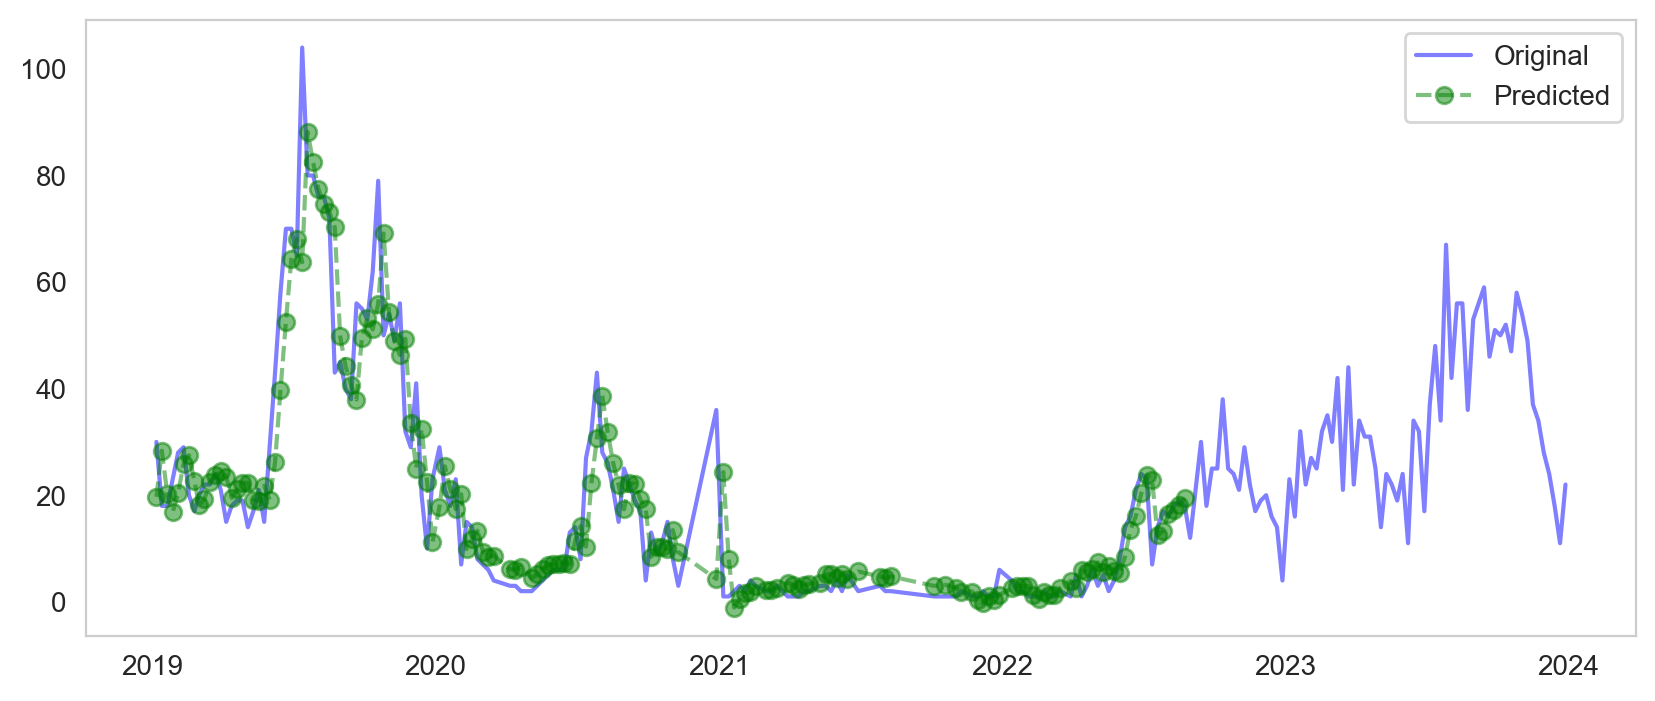

ME: -0.08, RMSE: 8.09, MAPE: 75.54%, WAPE: 27.44%


In [195]:
plt.figure(figsize=(10,4))
plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
plt.plot(model.predict()['total_case'], marker='o', linestyle='--', alpha=0.5, color='green', label='Predicted')
plt.legend()
plt.show()

get_forecast_accuracy(Y_train['total_case'], model.predict()['total_case'])

MAPE ยิ่งน้อยยิ่งดี , WAPE ยิ่งมากยิ่งแม่น

ME: -0.11, RMSE: 7.90, MAPE: 80.76%, WAPE: 28.45%

In [130]:
history = [y for y in Y_train.values]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 1
for t in range(len(Y_test)-(h-1)):
      
  model_fit = VARMAX(train, order=best_pq).fit(disp=False)
    
  output = model_fit.get_forecast(h)
  predictions.append(output.predicted_mean[h-1])
  lower_ci.append(output.conf_int()[h-1, 0])
  upper_ci.append(output.conf_int()[h-1, 3])

  history.append(Y_test.iloc[t])
  train = history[t+1:]

<Figure size 800x400 with 0 Axes>

ME: 1.19, RMSE: 9.42, MAPE: 29.62%, WAPE: 24.15%


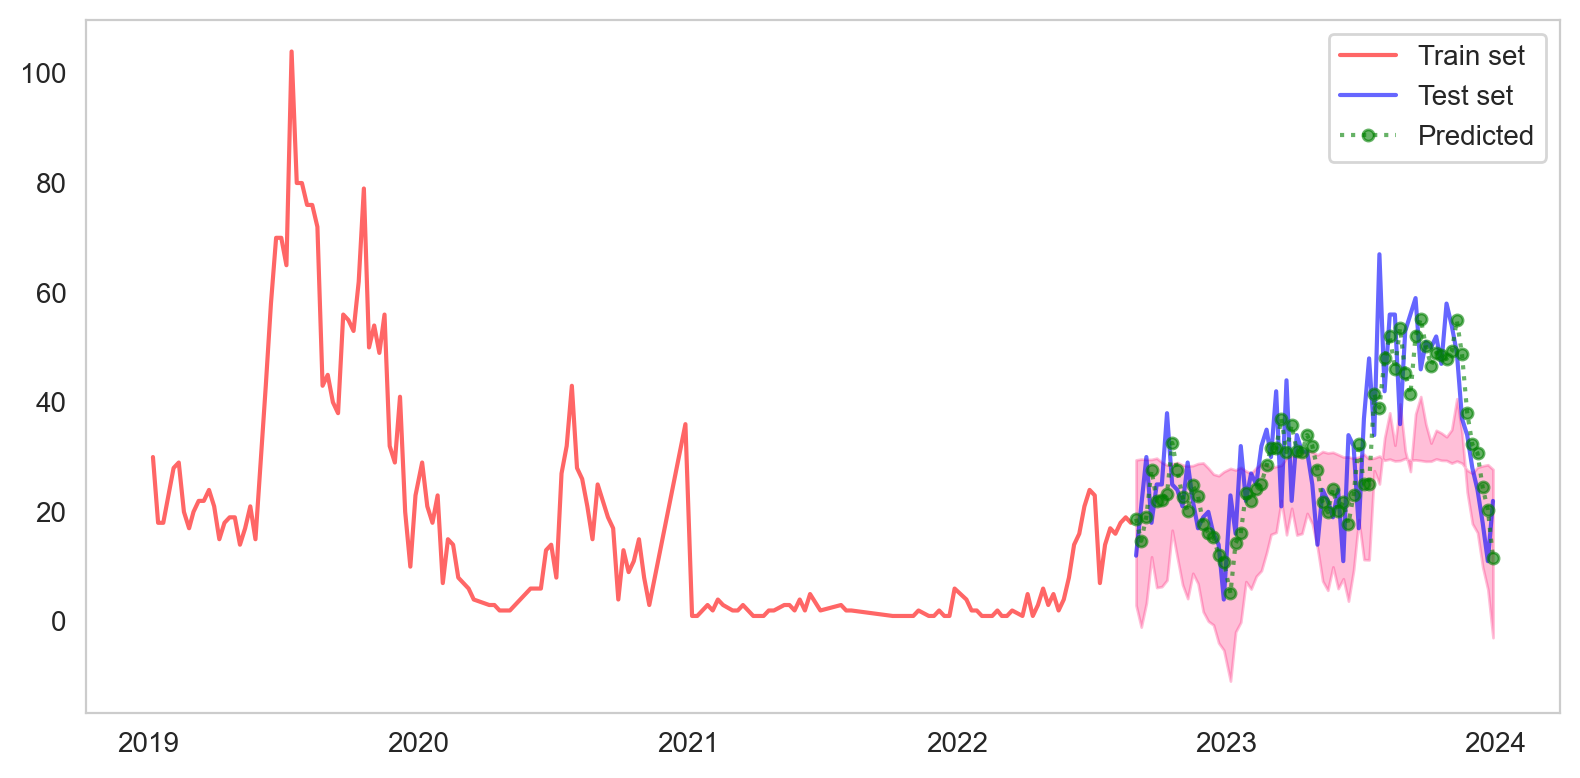

In [132]:
plt.figure(figsize=(8,4))
plt.plot(Y_train['total_case'], label='Train set', color='red', alpha=0.6); 
plt.plot(Y_test['total_case'], label='Test set', color='blue', alpha=0.6); 

predictions_con = pd.Series([i[0] for i in predictions], index=Y_test.index[h-1:])
plt.plot(predictions_con, 'go:', label='Predicted', alpha=0.6, ms=4) 
plt.fill_between(Y_test.index[h-1:], upper_ci, lower_ci, color='#ff0066', alpha=.25)
plt.legend(loc='best')
plt.tight_layout();

get_forecast_accuracy(Y_test['total_case'][h-1:], predictions_con)

In [202]:
uscon.tail(161)

,total_case,temp
date,,
2020-06-09,6,28.151734
2020-06-16,6,27.849440
2020-06-23,13,27.658743
2020-06-30,14,28.000574
2020-07-07,8,27.713360
...,...,...
2023-12-01,28,26.863721
2023-12-08,24,26.813490
2023-12-15,18,27.116654


In [ ]:
results.tail(52)

In [197]:
results = model.forecast(52)

In [ ]:
results['total_case']

In [1]:
h = 52


results = model.forecast(h)

plt.figure(figsize=(10,4))
plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
plt.plot(results['total_case'], linestyle='--', alpha=0.5, color='red', label='Predicted')
plt.legend()
plt.show()

NameError: name 'model' is not defined

<Figure size 1000x400 with 0 Axes>

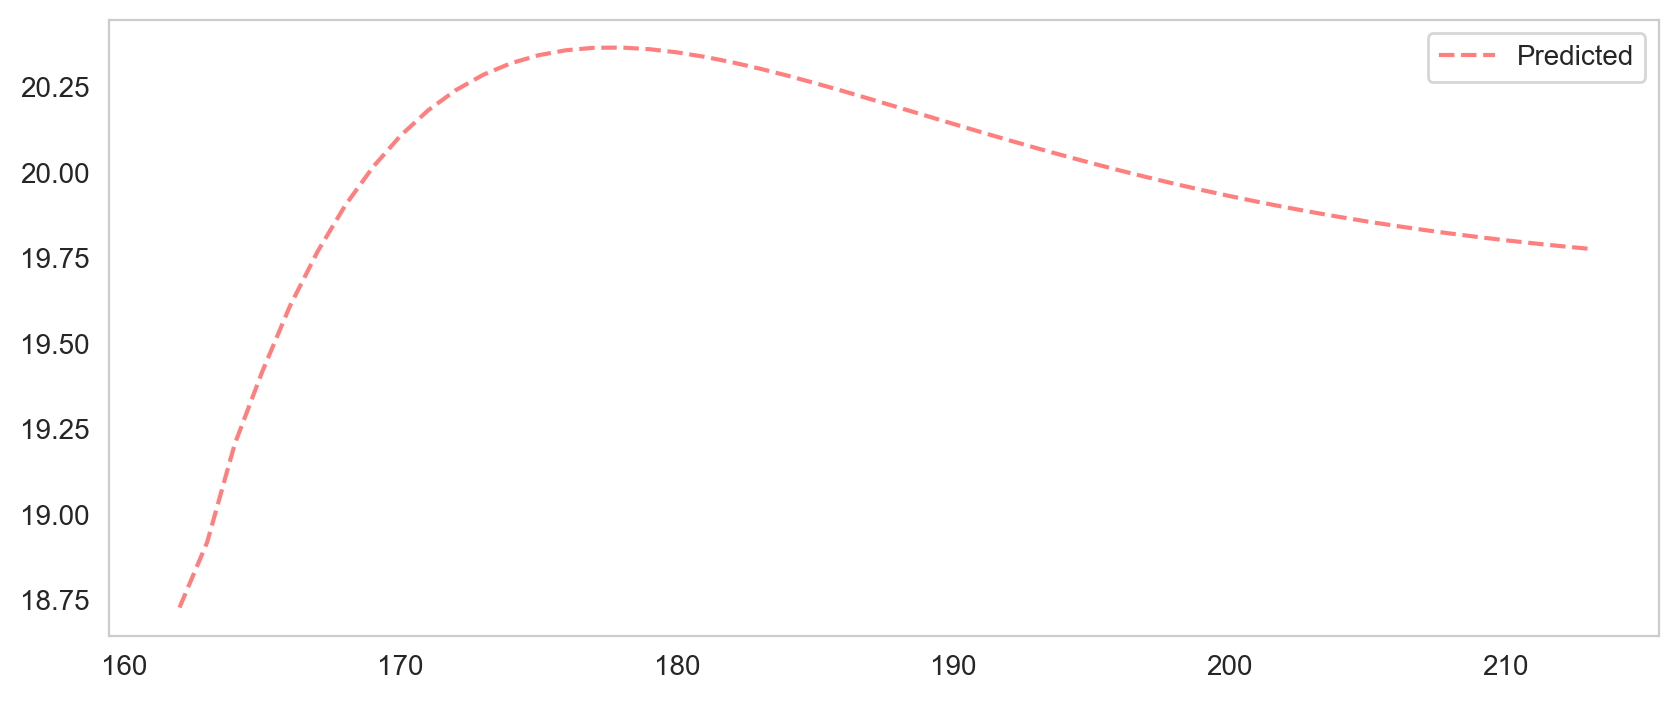

In [201]:
h = 52


results = model.forecast(h)

plt.figure(figsize=(10,4))
# plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
plt.plot(results['total_case'], linestyle='--', alpha=0.5, color='red', label='Predicted')
plt.legend()
plt.show()

<Figure size 2000x400 with 0 Axes>

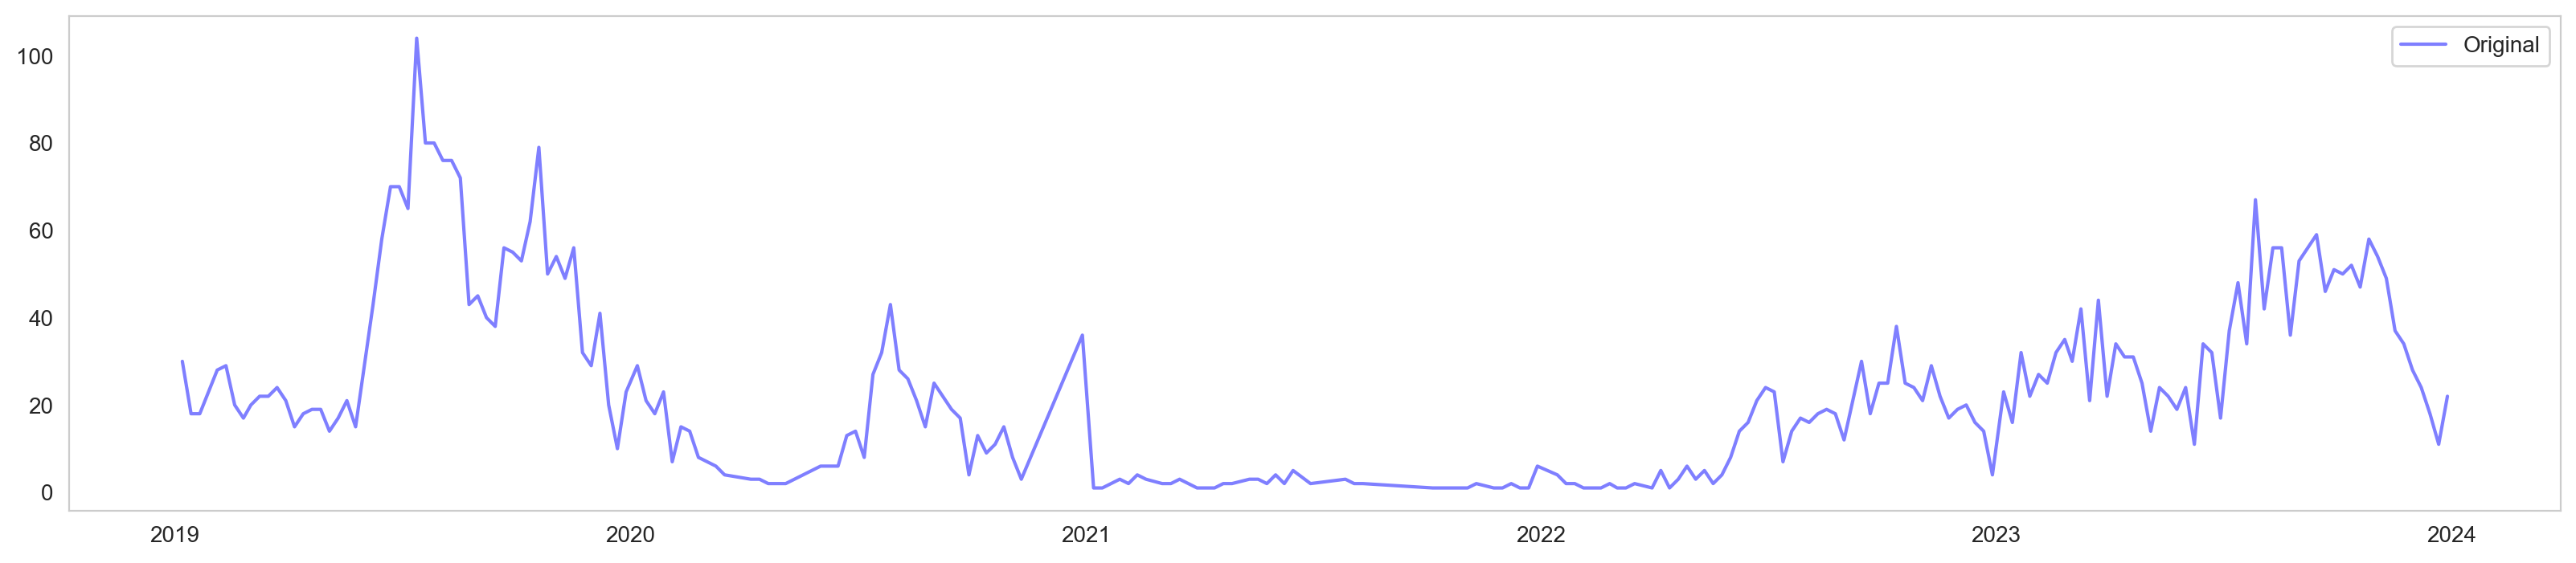

In [192]:
plt.figure(figsize=(20,4))
plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
# plt.plot(results['total_case'], linestyle='--', alpha=0.5, color='red', label='Predicte')
plt.legend()
plt.show()

In [188]:
uscon['total_case'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2019-01-07 to 2023-12-29
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  232 non-null    int64  
 1   temp        232 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.4 KB


In [193]:
results['total_case'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 52 entries, 162 to 213
Series name: total_case
Non-Null Count  Dtype  
--------------  -----  
52 non-null     float64
dtypes: float64(1)
memory usage: 548.0 bytes


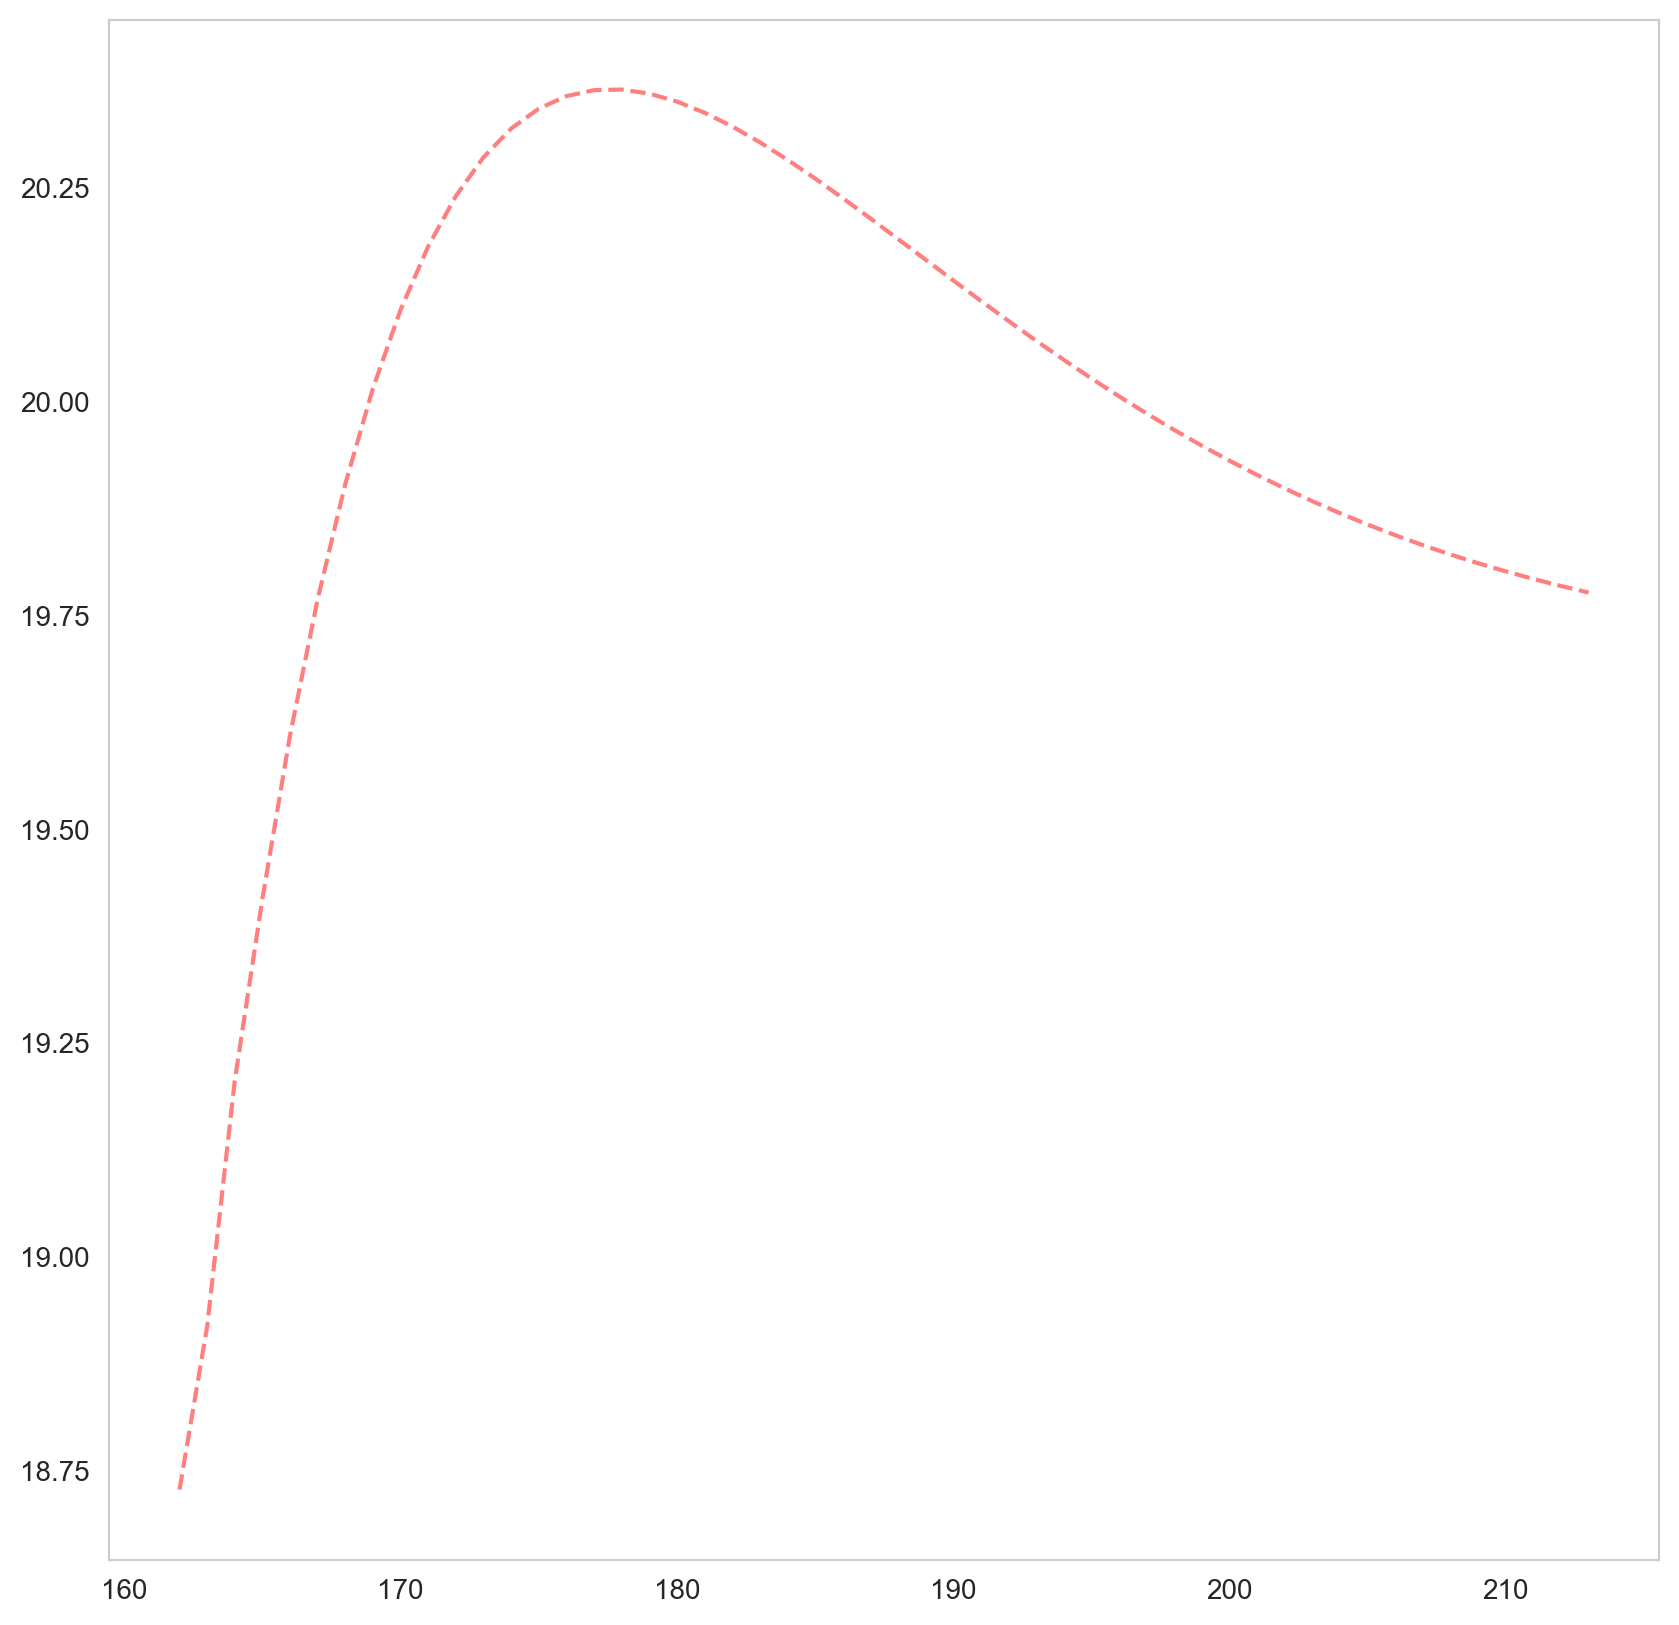

In [180]:
plt.plot(results['total_case'], linestyle='--', alpha=0.5, color='red', label='Predicted')